In [1]:
! nvidia-smi

Sat Jan 30 23:17:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
 ! pip install -q kaggle
 from google.colab import files
 from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Get kaggle token and downaload dataset

In [ ]:
# ! mkdir ~/.kaggle
# ! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download jerzydziewierz/bee-vs-wasp --unzip

In [ ]:
# ! cp -a  /content/kaggle_bee_vs_wasp /content/gdrive/MyDrive/

In [6]:
from fastai.vision import *
import torchvision.transforms as T
from PIL import Image

img_pil = Image.open("/content/gdrive/MyDrive/kaggle_bee_vs_wasp/bee1/10166485783_9cd6706c72_n.jpg")

In [7]:
pip install fastai --upgrade &> /dev/null # &> /dev/null - hides output

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision.all import *
from fastai.metrics import error_rate

# additional classic imports
from pathlib import Path
import pandas as pd
import numpy as np
import random

In [9]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *

In [16]:
from fastai import __version__
print(__version__)

2.2.5


In [17]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [10]:
bs = 64 # Batch size
resize_size = 192 # for training, resize all the images to a square of this size
training_subsample = 1 # dla lr_find użyto 0.05, dla uczenia docelowego modelu 1

In [11]:
bees_vs_wasps_dataset_path=Path('/content/gdrive/MyDrive/kaggle_bee_vs_wasp/') 
df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels=df_labels.set_index('id')

In [12]:
df_labels[['path']] = df_labels[['path']].replace(to_replace= r'\\', value= r'/', regex=True)

In [13]:
df_labels.count()

path                   11421
is_bee                 11421
is_wasp                11421
is_otherinsect         11421
is_other               11421
photo_quality          11421
is_validation          11421
is_final_validation    11421
label                  11421
dtype: int64

In [14]:
df_testSet = df_labels.loc[df_labels['is_final_validation'] == 1]
df_training = df_labels[df_labels.is_final_validation != 1]

In [18]:
df_testSet['label'].count()

1763

In [19]:
df_training['label'].count()

9658

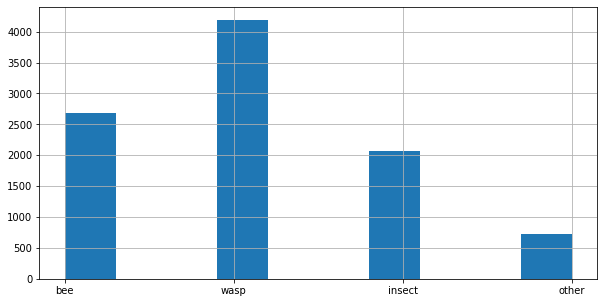

In [20]:
df_training['label'].hist(figsize = (10, 5))

In [21]:
df_training['label'].value_counts()

wasp      4190
bee       2679
insect    2063
other      726
Name: label, dtype: int64

In [22]:
df_other = df_training.loc[df_training['label'] == 'other']
df_insect = df_training.loc[df_training['label'] == 'insect']
df_bee = df_training.loc[df_training['label'] == 'bee']

basic data balance - oversampling by copy

In [23]:
df_training= df_training.append(df_other, ignore_index=True)
df_training= df_training.append(df_other, ignore_index=True)
df_training= df_training.append(df_other, ignore_index=True)
df_training= df_training.append(df_other, ignore_index=True)
df_training= df_training.append(df_other.iloc[0:550], ignore_index=True)
df_training= df_training.append(df_insect, ignore_index=True)
df_training= df_training.append(df_bee.iloc[0:1500], ignore_index=True)

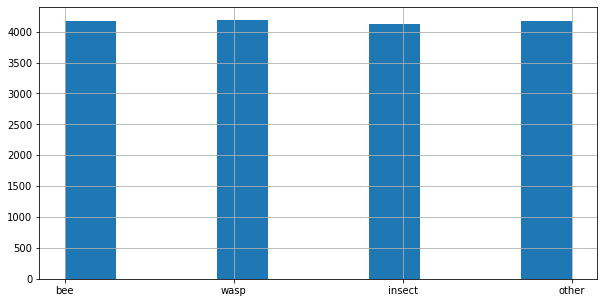

In [24]:
df_training['label'].hist(figsize = (10, 5))

shuffle data - randomize


In [25]:
from sklearn.utils import shuffle
df_training = shuffle(df_training)

In [26]:
df_training['label'].value_counts()

wasp      4190
other     4180
bee       4179
insect    4126
Name: label, dtype: int64

In [27]:
df_training = df_training.sample(frac=training_subsample, axis=0)
df_training.head(10)

,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
732,bee1/3096286007_ed610c2e56_n.jpg,1,0,0,0,1,0,0,bee
9459,other_noinsect/559695.jpg,0,0,0,1,0,0,0,other
2460,bee2/P20396-47r.jpg,1,0,0,0,0,0,0,bee
7982,other_insect/40465916291_d4ee8d42f2_n.jpg,0,0,1,0,1,0,0,insect
9276,other_noinsect/538661.jpg,0,0,0,1,0,0,0,other
10861,other_noinsect/553795.jpg,0,0,0,1,0,0,0,other
10972,other_noinsect/565902.jpg,0,0,0,1,0,0,0,other
2819,wasp1/14598159003_bc8567e84a_n.jpg,0,1,0,0,1,0,0,wasp
2006,bee1/9390470814_f1a31d4606_n.jpg,1,0,0,0,1,0,0,bee
13940,other_insect/3386614953_0cae543f80_w.jpg,0,0,1,0,1,1,0,insect


In [28]:
df_training['label'].count()

16675

In [30]:
data = ImageDataLoaders.from_df(
    df = df_training,
    path = Path(bees_vs_wasps_dataset_path),
    valid_pct=0.2,
    seed = 5,
    fn_col='path',
    folder=None,
    label_col='label',
    bs=bs,
    shuffle_train=True,
    batch_tfms=aug_transforms(),
    item_tfms=Resize(resize_size),
    device='cuda', 
    num_workers=0
)

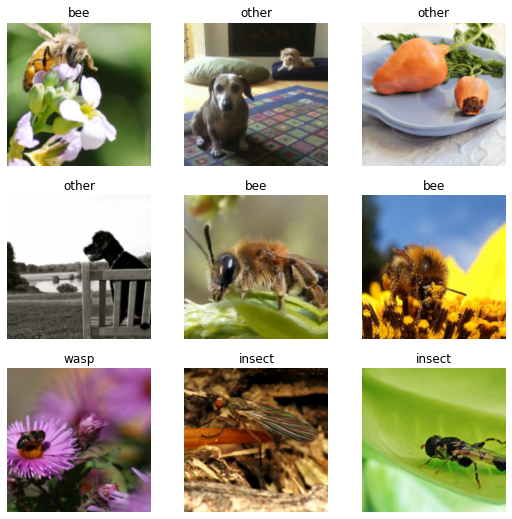

In [ ]:
data.show_batch()

In [31]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=true)
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
# learn.summary()

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage0.pth')

0.0003981071524322033 0.000630957365501672


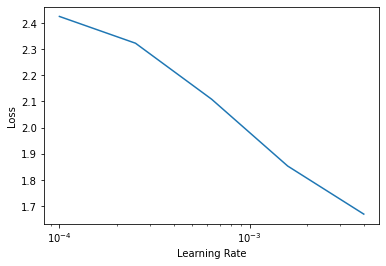

In [ ]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
best, step = learn.recorder.lr_find(start_lr=1e-04, end_lr=1, num_it=10) 
print(best, step)

In [ ]:
# learn.summary()

Model frozen up to parameter group #2 - training only fully contected classifying layers

fit_one_cycle - uses cyclical learning rates

* https://arxiv.org/abs/1506.01186
* https://iconof.com/1cycle-learning-rate-policy/
* https://course.fast.ai/videos/?lesson=6 - learning rate, transfer learning



# Make trainable -fully connected layers - classification - Total trainable params: 2,161,536

In [228]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
learn.recorder.fit_one_cycle(2, lr_max=slice(1e-4,1e-2)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.245360,0.180116,0.948726,03:24
1,0.143553,0.112657,0.962819,03:26


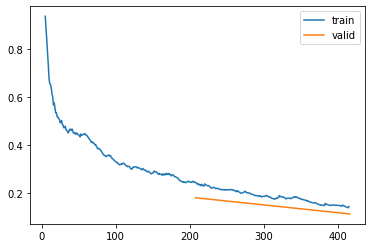

In [230]:
learn.recorder.plot_loss()

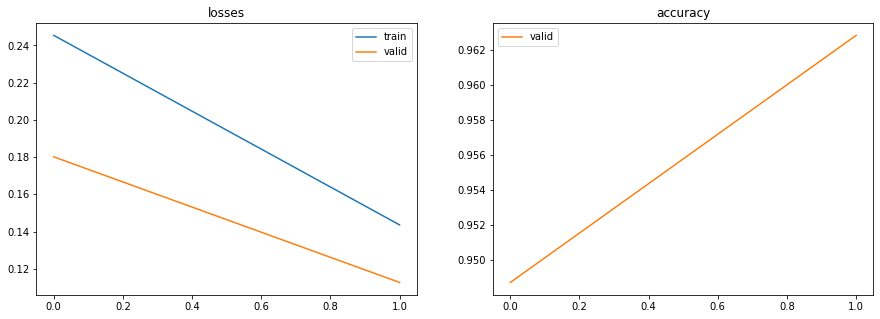

In [238]:
learn.recorder.plot_metrics(figsize=(15,5))

In [242]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage1')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage1.pth')

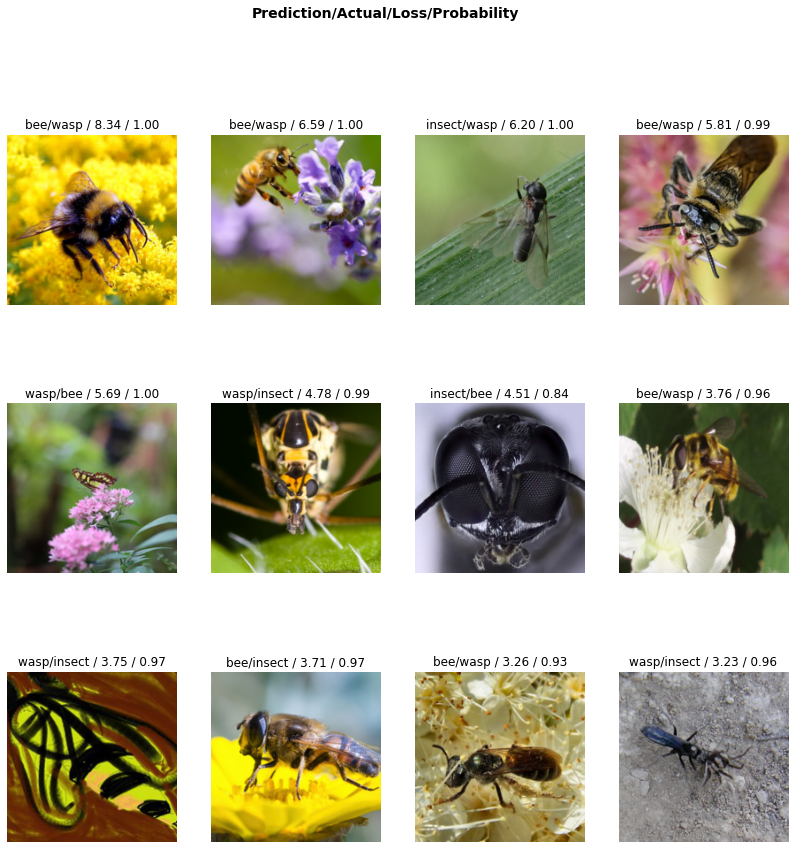

In [33]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage1')
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(12, figsize=(14,14))

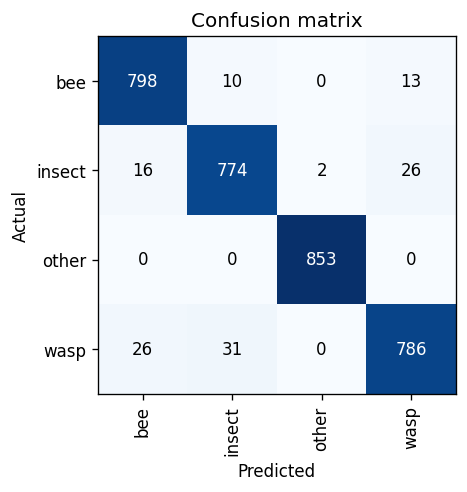

In [241]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [34]:
def getTestsetAccuracy(learn):
  path_core= '/content/gdrive/MyDrive/kaggle_bee_vs_wasp/'
  good_prediction = 0
  wrong_prediction = 0
  for index, row in df_testSet.iterrows():
    path = row['path']
    img_path = path_core + path
    if row['label'] == learn.predict(img_path)[0]:
      good_prediction +=1
    else:
      wrong_prediction +=1
  accuracy = 1 - (wrong_prediction / good_prediction)
  print(accuracy)

In [324]:
getTestsetAccuracy(learn)

0.9417767106842737


In [35]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage1')

https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

https://medium.com/analytics-vidhya/understanding-fastai-v2-training-with-a-computer-vision-example-part-3-fastai-learner-and-a3ea85c6fe78

In [ ]:
learn.model[0][7][2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

# Make trainable - last conv layer - Total trainable params: 3,210,112


In [37]:
# for param in learn.model.parameters():
#   param.requires_grad = False

learn.freeze()

for param in learn.model[0][7][2].conv3.parameters():
  param.requires_grad = True
 
for param in learn.model[0][7][2].bn3.parameters():
  param.requires_grad = True

learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
# uncomment to check trainable parameters
# learn.summary() 

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage2.pth')

6.30957356406725e-07 1.4677992510314652e-07


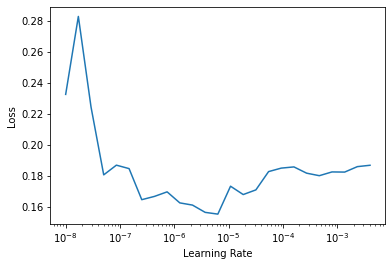

In [ ]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
best, step = learn.recorder.lr_find(start_lr=1e-08, end_lr=1e-01, num_it=30) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.129230,0.086270,0.971214,03:23


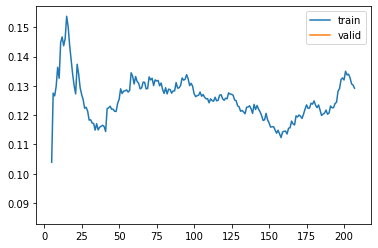

In [38]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-8,1e-6)) 
learn.recorder.plot_loss()

In [39]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage3')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage3.pth')

In [40]:
getTestsetAccuracy(learn)

0.9379518072289157


In [55]:
learn.freeze()

for param in learn.model[0][7][2].conv2.parameters():
  param.requires_grad = True

for param in learn.model[0][7][2].bn2.parameters():
  param.requires_grad = True  

for param in learn.model[0][7][2].conv3.parameters():
  param.requires_grad = True
 
for param in learn.model[0][7][2].bn3.parameters():
  param.requires_grad = True

learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
# learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 96 x 96   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 48 x 48  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

# Make trainable - last 2 conv layers - Total trainable params: 5,569,408

5.411695383372717e-06 2.5118865210060903e-07


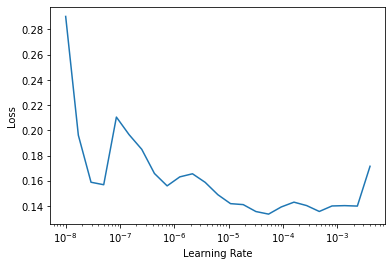

In [43]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
best, step = learn.recorder.lr_find(start_lr=1e-08, end_lr=1e-01, num_it=30) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.123506,0.087474,0.971214,03:22


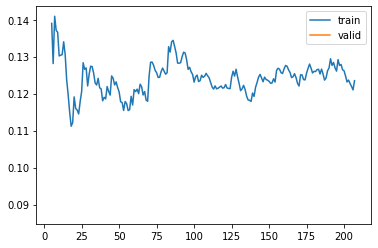

In [46]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-5,1e-4)) 
learn.recorder.plot_loss()

In [45]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage4')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage4.pth')

In [47]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage4')
getTestsetAccuracy(learn)

0.9392298435619735


Unfreeze all layers - whole net trainable

In [56]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 96 x 96   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 48 x 48  
Conv2d                                    16384      True      
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

2.7542286229476077e-10 9.120108557247875e-10


Path('/content/gdrive/MyDrive/model_stages/resnet50-stage5.pth')

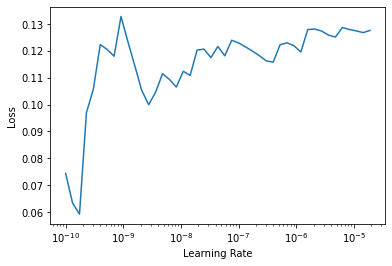

In [57]:
best, step = learn.recorder.lr_find(start_lr=1e-10, end_lr=1e-4, num_it=50) 
print(best, step)
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage5')

epoch,train_loss,valid_loss,accuracy,time
0,0.131141,0.084501,0.971214,03:46


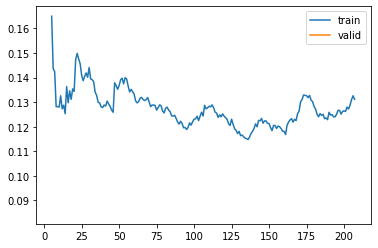

In [53]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage5')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-8,1e-7)) 
learn.recorder.plot_loss()

In [54]:
getTestsetAccuracy(learn)

0.9405048076923077


In [ ]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage6')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage5.pth')